# Determining the PSF of APF - small scale implementation
Run the laser detection algorithm on thorium-argon lamp spectra to determine the minimum width of the signals that pass through the APF.
This is the small scale implementation to make sure that it works: I only use one file (rcob.220.fits) and one order (40).

In [2]:
import astropy.io.fits as fits
import matplotlib.pylab as plt
import numpy as np
from scipy.interpolate import interp1d
from scipy.interpolate import splev, splrep
import math
from mpmath import mp
import os
import os.path 
import random
from random import seed
from random import choice
import scipy.interpolate

In [3]:
def chi(model, data):
    '''given two arrays of the same length, calculate chi-squared'''
    return np.sum((data - model) ** 2)

mp.dps=100
exp_array = np.frompyfunc(mp.exp, 1, 1)

def gaussian(x,a,b,c,d): # a = height, b = position of peak, c = width, x = numpy array of x values
    f = a*exp_array((-(x-b)**2)/(2*c)**2) + d
    return f 

## Set parameters

In [4]:
SDs_above_median = 3   # number of SDs above the median the signal has to be in order to be detected
plot = True  # plt.show()

# ignore
save_figs = False  # save figures into folders
inject_signals = False  # inject signals into data
random_injections = False  # randomly inject signals into data
num_random_injections = 0  # number of injected signals
allow_overlap = False  # whether or not to allow injected signals to overlap
use_local_median = False   # when calculating median of spectra, use 3000 pixels to the left and right of the index instead of the entire spectrum
threshold_testing = False   # visualize which heights and widths go detected
only_test_certain_range = False  # whether or not to trucnate the spectra or run the algorithm on its entirety 
min_index = 0  # if truncating, which index to start at
max_index = 1000  # if truncating, which index to end at

## Read in Data from APF

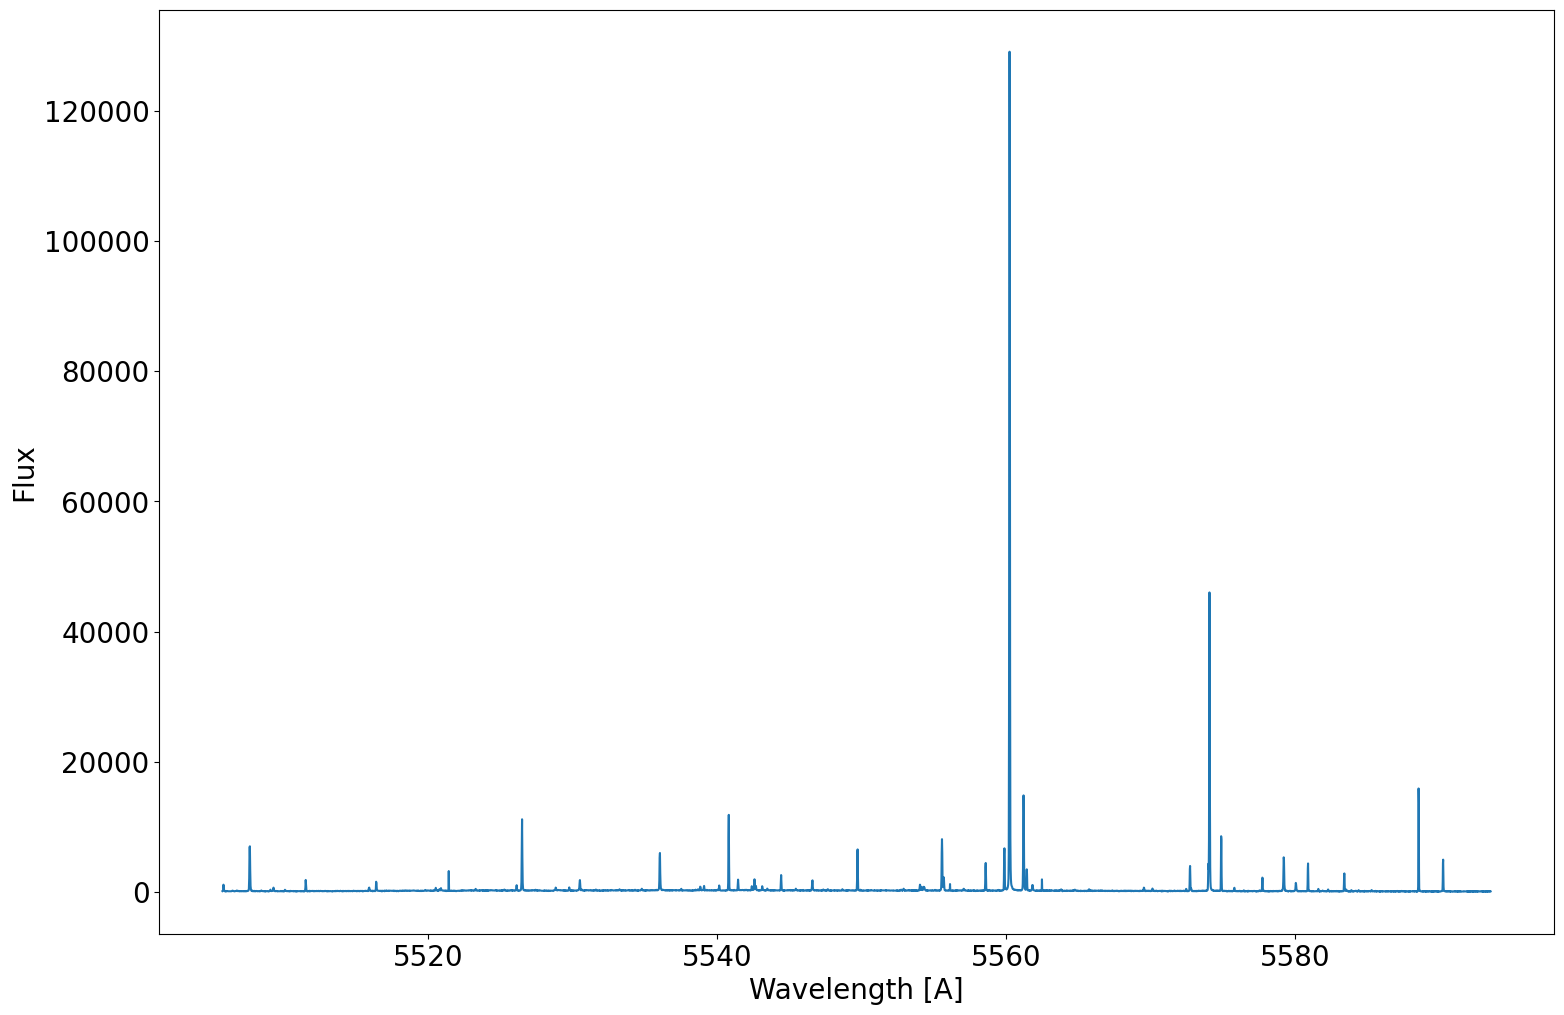

In [5]:
plt.rcParams["figure.figsize"] = (18,12)
plt.rcParams.update({'font.size': 20})

APF_wavelength_path = '/mnt_home/zoek/code/APF-BL-DAP/Zoe/APFTutorial/apf_wav.fits'
APF_flux_path = '/mnt_home/zoek/code/APF-BL-DAP/Zoe/APF_PSF/rcob.220.fits'

wl_file = fits.open(APF_wavelength_path)
fl_file = fits.open(APF_flux_path)
wl_image = wl_file[0].data
fl_image = fl_file[0].data

order = 40

wl = wl_image[order]
flux = fl_image[order][:-1]
plt.plot(wl,flux)
# plt.ylim(0, 500)

plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.show()

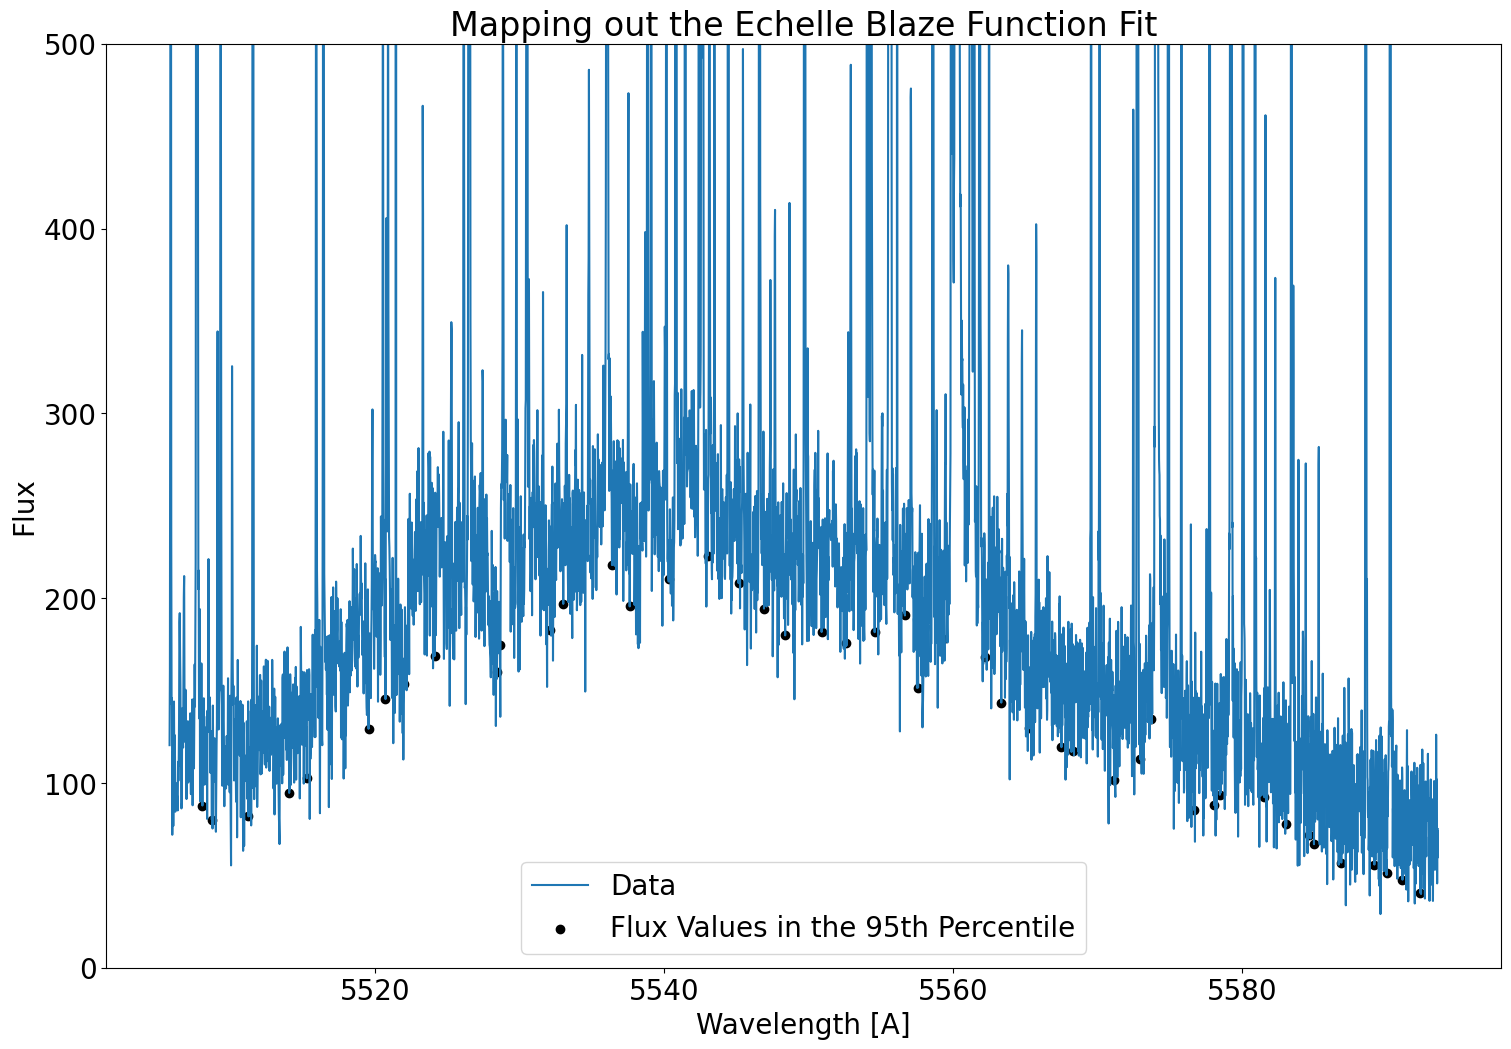

In [6]:
bin = 100

# this list will contain the indices corresponding to each of the 95th percentile flux values in each bin
indices = []

for i in np.arange((len(wl) - (bin)), step = bin):
    flux_values = []
    for j in np.arange(i, i + bin, step = 1):
        value = flux[j]
        flux_values = np.append(flux_values, value)
    # find the 5th percentile flux value: we use 5 to get the minimum flux value in general 
    # but avoid issues with absorption lines
    flux_in_bin = np.percentile(flux_values, 5)
    # find the closest value in the flux array to the 95th percentile value
    absolute_difference_function = lambda list_value : abs(list_value - flux_in_bin)
    flux_in_bin = min(flux_values.tolist(), key=absolute_difference_function)
    index_in_bin = flux_values.tolist().index(flux_in_bin)
    index = i + index_in_bin
    indices = np.append(indices, index)

# these lists will contain the wavlength and flux values at each index in 'indices'
wl_values = []
fl_values = []

for index in indices:
    ind = int(index)
    wl_values = np.append(wl_values, wl[ind])
    fl_values = np.append(fl_values, flux[ind])
    
plt.plot(wl, flux, label = 'Data')
plt.scatter(wl_values, fl_values, color = 'black', label = 'Flux Values in the 95th Percentile')
plt.title('Mapping out the Echelle Blaze Function Fit')
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.ylim(0, 500)
plt.legend()
plt.show()

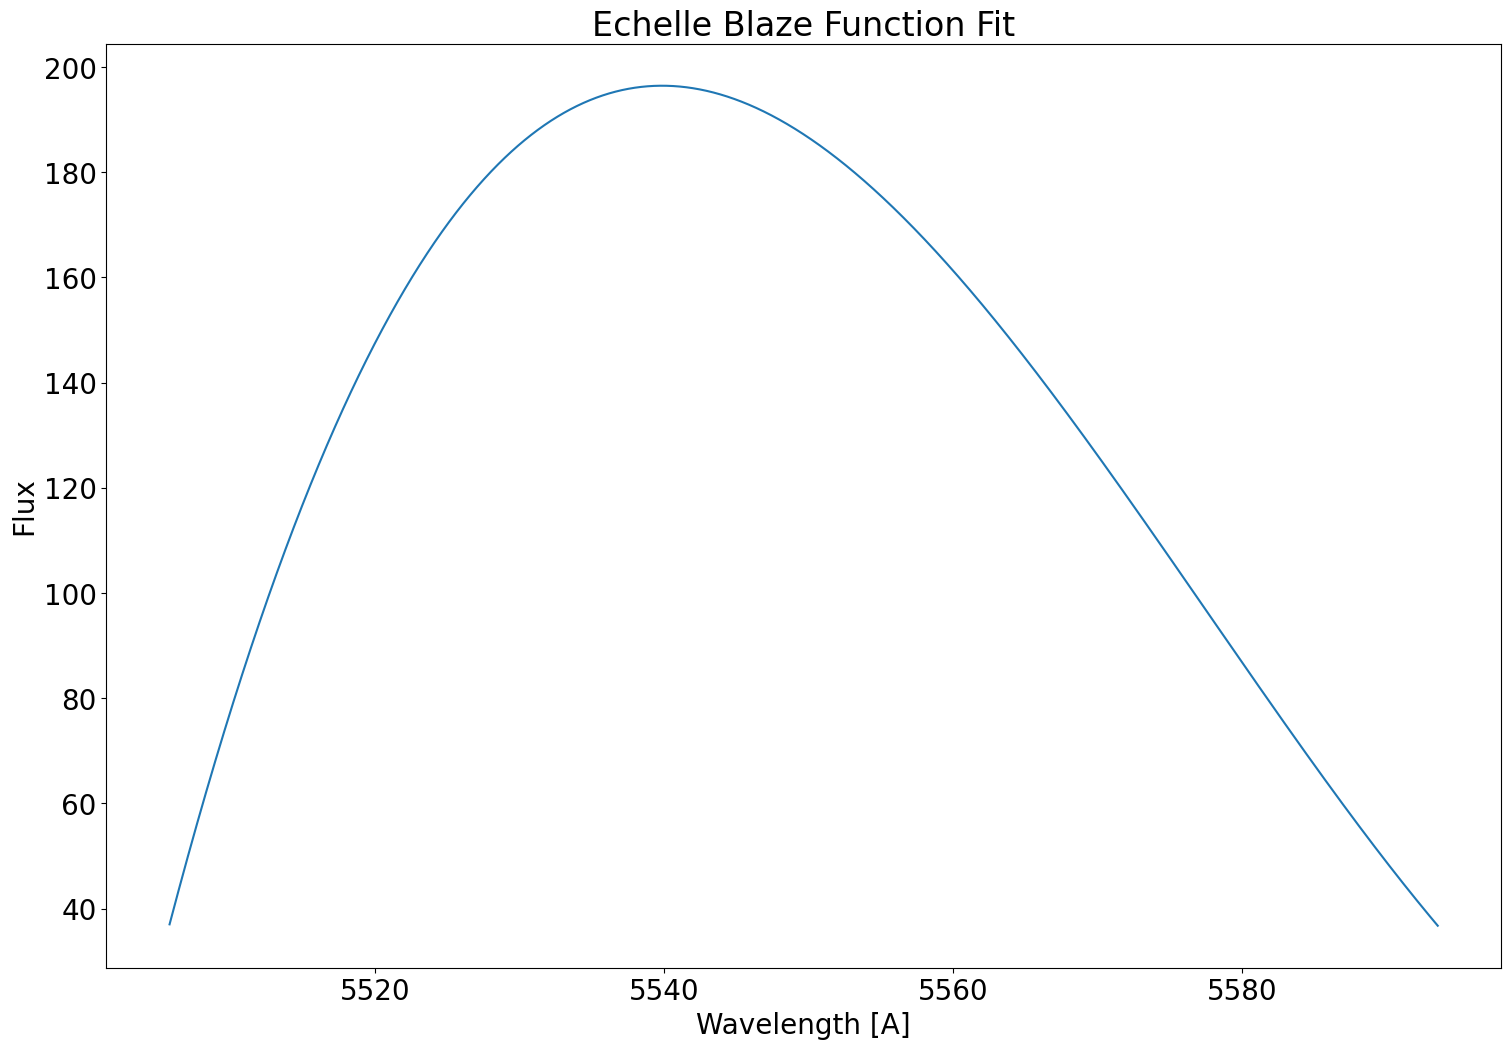

In [7]:
spl = splrep(wl_values, fl_values, s = 500000)
flux_fit = splev(wl, spl)
plt.plot(wl, flux_fit)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Echelle Blaze Function Fit')
plt.show()

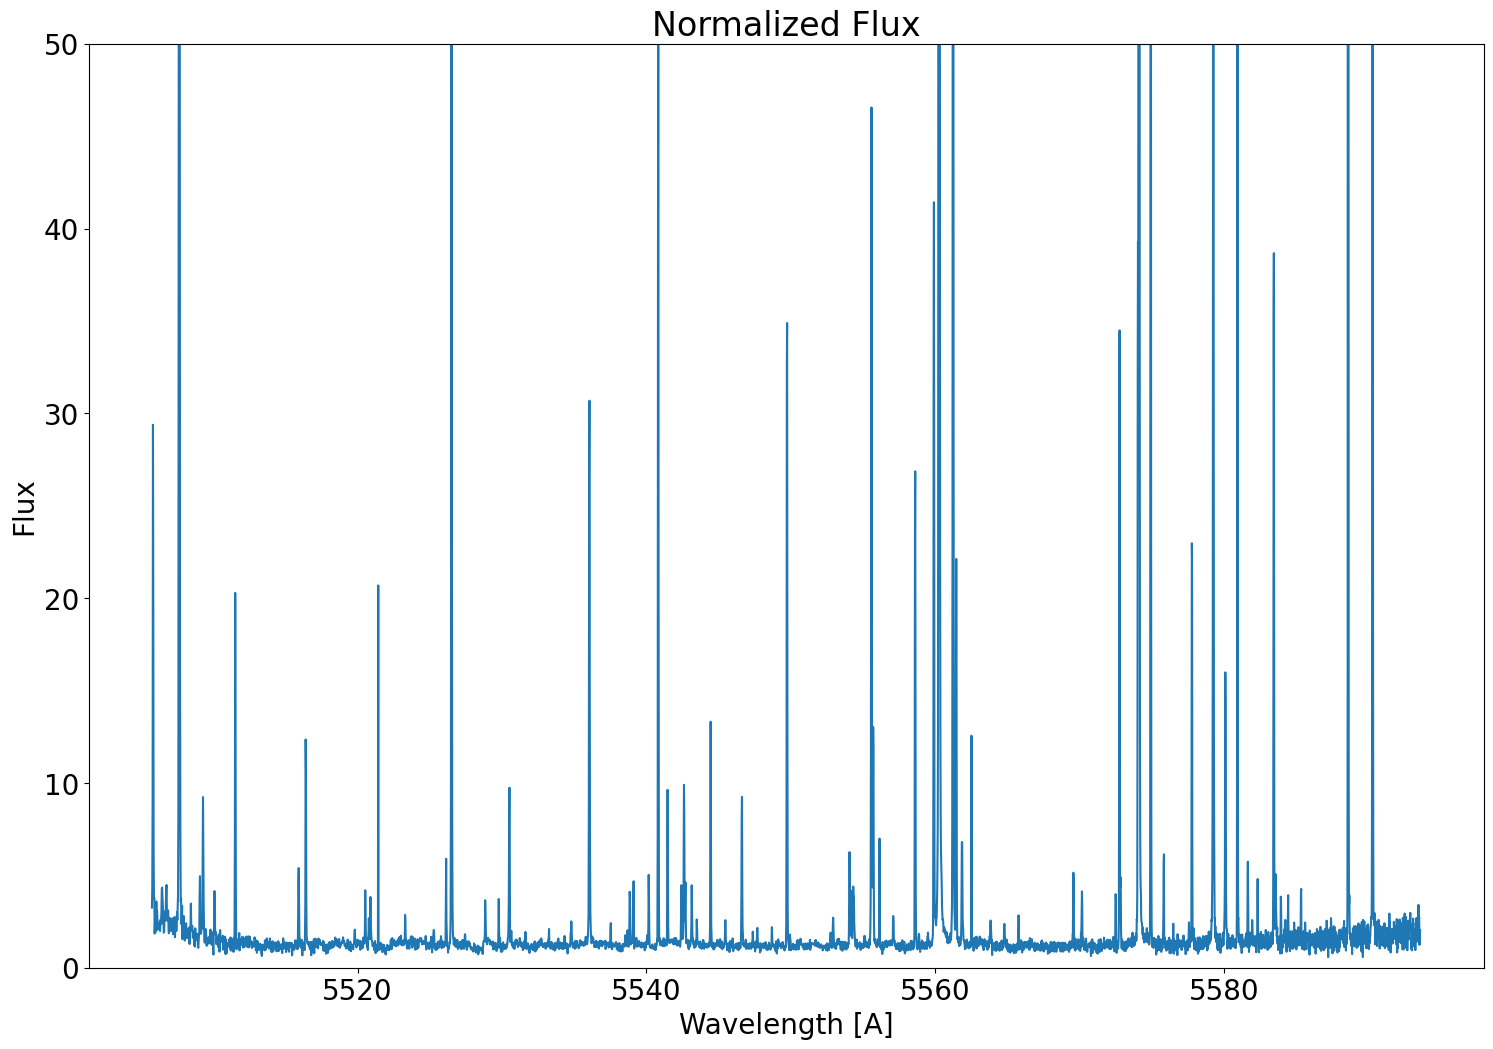

In [8]:
first_normalized_flux = flux / flux_fit
plt.plot(wl, first_normalized_flux)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Normalized Flux')
plt.ylim(0, 50)
plt.show()

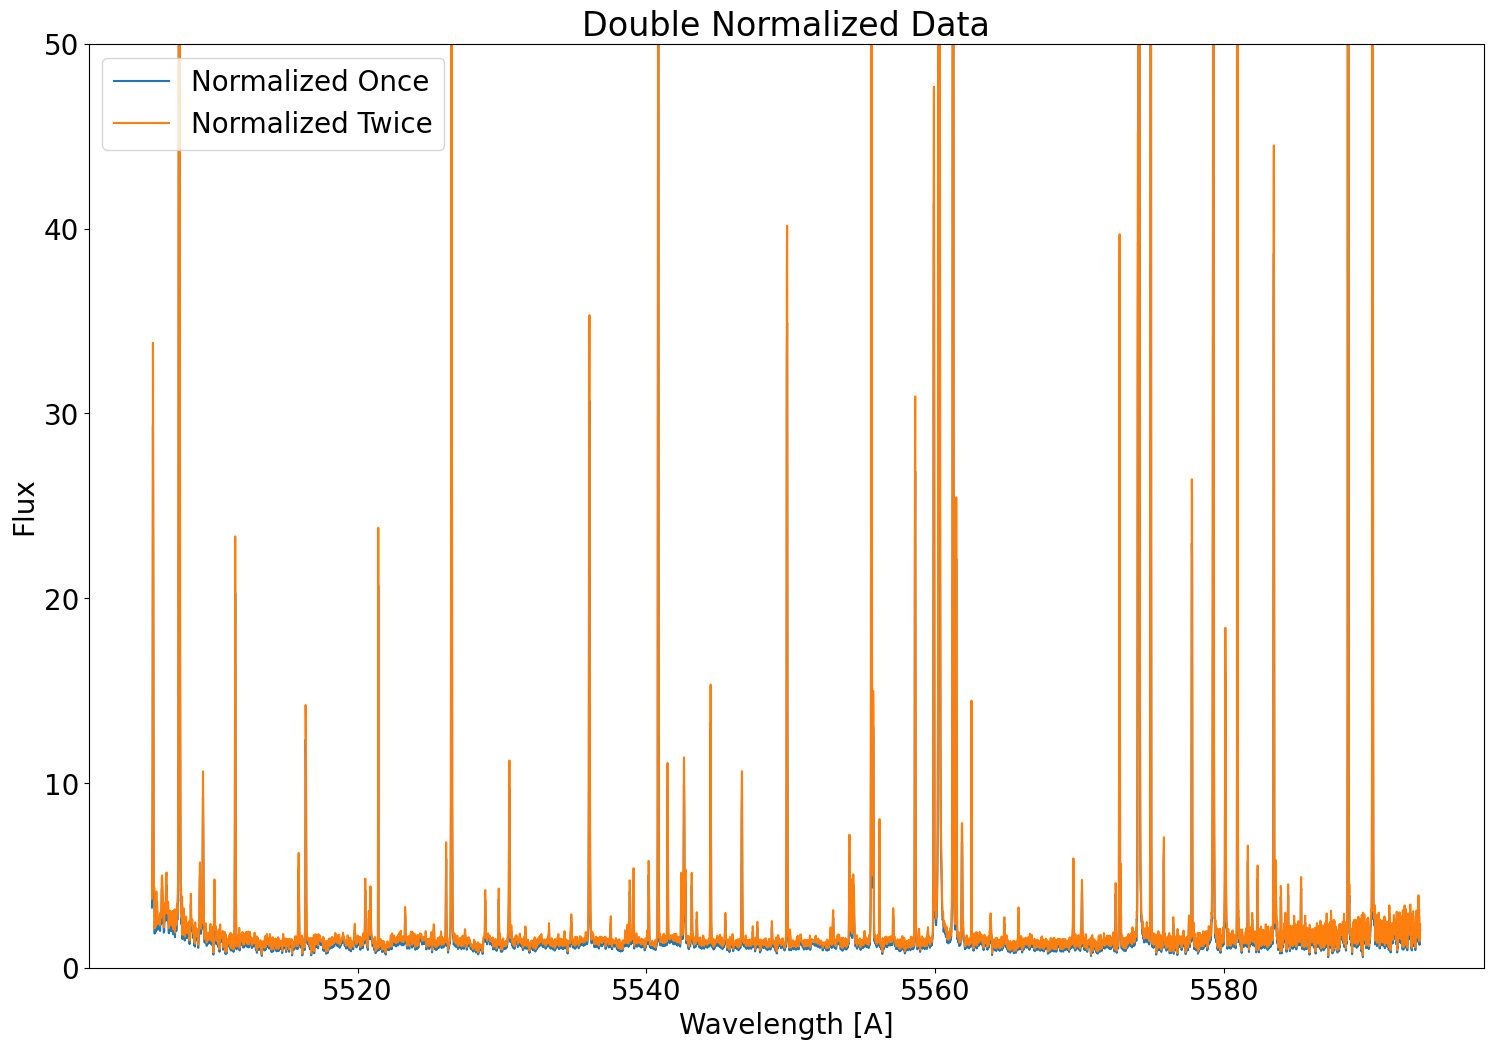

In [9]:
flux2 = np.percentile(first_normalized_flux, 2)
normalized_flux = first_normalized_flux / flux2

plt.plot(wl, first_normalized_flux, label = 'Normalized Once')
plt.plot(wl, normalized_flux, label = 'Normalized Twice')
plt.legend()
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Double Normalized Data')
plt.ylim(0, 50)
plt.show()

In [10]:
flux = normalized_flux
spect = flux

In [11]:
# median = np.median(spect)
# SD = np.std(spect)

idxs1 = [] # indicies that are 3 SDs above the median flux value
idxs2 = [] # indicies in idxs1 that are local maximums
idxs3 = [] # indicies in idxs2 that are greater than 5 pixels in width
idxs4 = [] # indicies in idxs3 that are gaussian-shaped

median = np.median(spect)
SD = np.std(spect)
    
for idx in np.arange(len(spect)):
    # first test: create an array of all indices that are above 3 SDs above GLOBAL median
    if spect[idx] > SDs_above_median * SD + median:
        idxs1 = idxs1 + [idx]

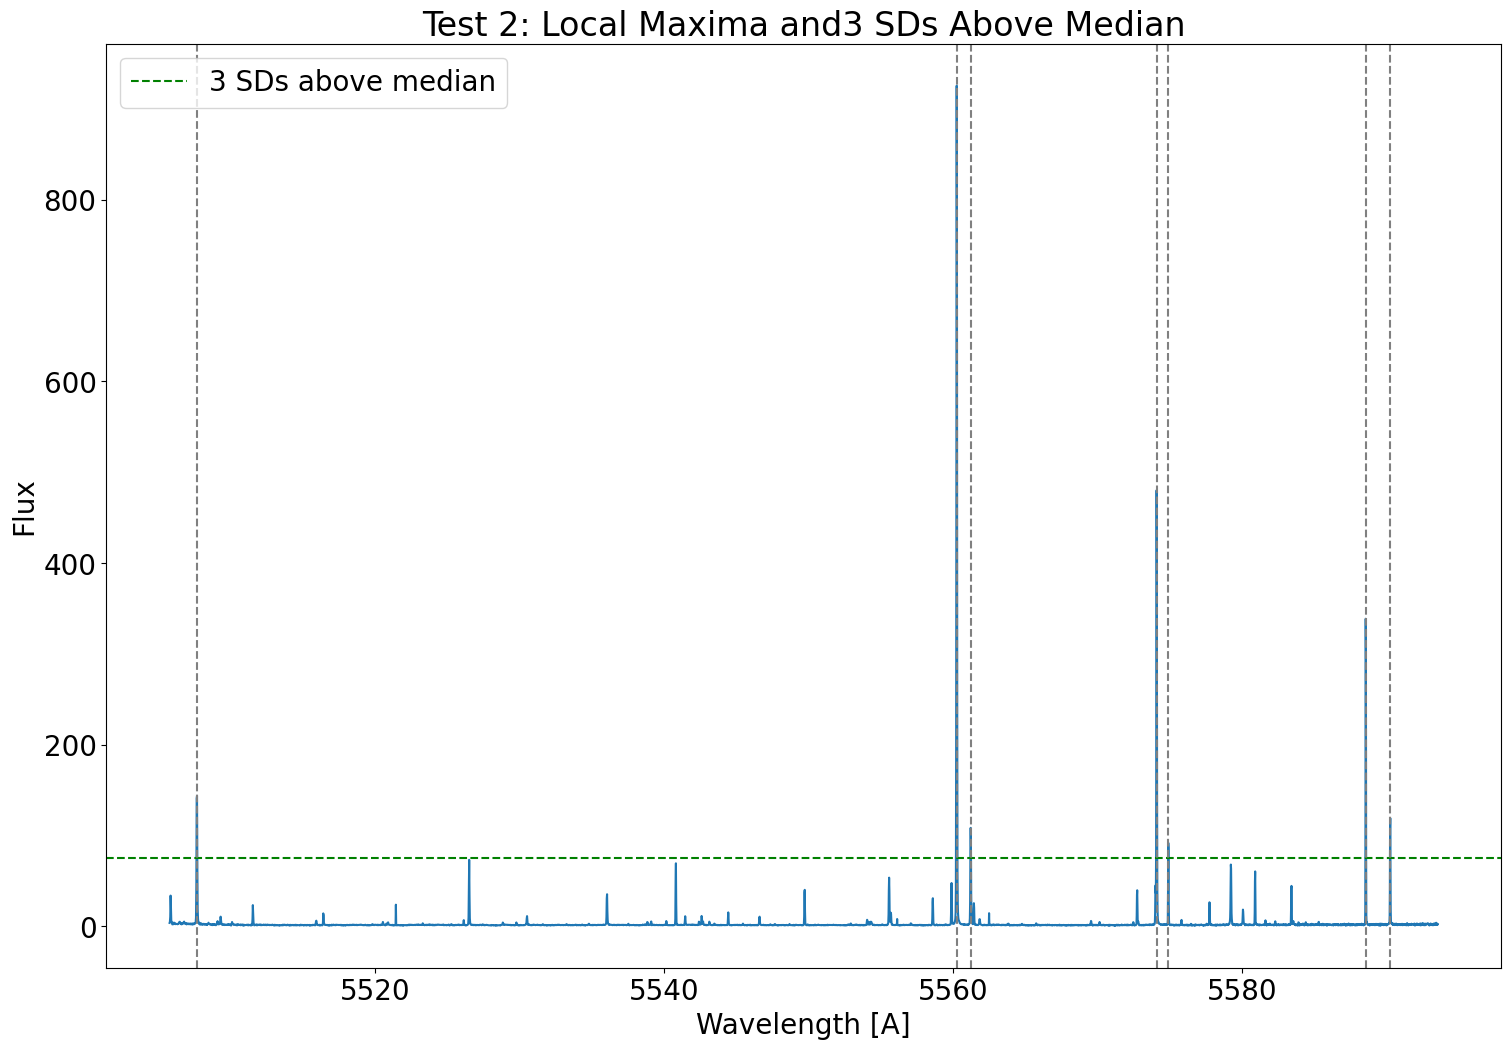

In [12]:
for idx in idxs1:            
    # second test: keep the index if it is a local maximum  
    if spect[idx] >= spect[idx-1] and spect[idx] >= spect[idx+1]: 
        if spect[idx] >= spect[idx-2] and spect[idx] >= spect[idx+2]:
            idxs2 = idxs2 + [idx]
            
if (plot == True or save_figs == True) & (idxs2 != []):
    fig = plt.figure()
    plt.plot(wl, spect)
    plt.axhline(SDs_above_median * SD + median, label= str(SDs_above_median) + ' SDs above median', color='green', linestyle='--')
    for ind in idxs2:
        plt.axvline(x=wl[ind], color='gray', linestyle='--')
#         plt.axvline(x=wl[ind], label= 'Detected Signal at ' + str(round(wl[ind], 2)) + ' A', color='gray', linestyle='--')    
    plt.title('Test 2: Local Maxima and' + str(SDs_above_median) + ' SDs Above Median')
    plt.xlabel('Wavelength [A]')
    plt.ylabel('Flux')
    plt.legend() 
    if plot == True:
        plt.show()
    if save_figs == True:
        path = '/mnt_home/zoek/code/APF-BL-DAP/Zoe/LaserDetectionResults/' + star
        if not (os.path.isdir(path)):
            os.mkdir(path)
        path = path + '/order' + str(order)
        if not (os.path.isdir(path)):
            os.mkdir(path)
        fig.savefig(path + '/' + star + '_order' + str(order) + '_test2.png')

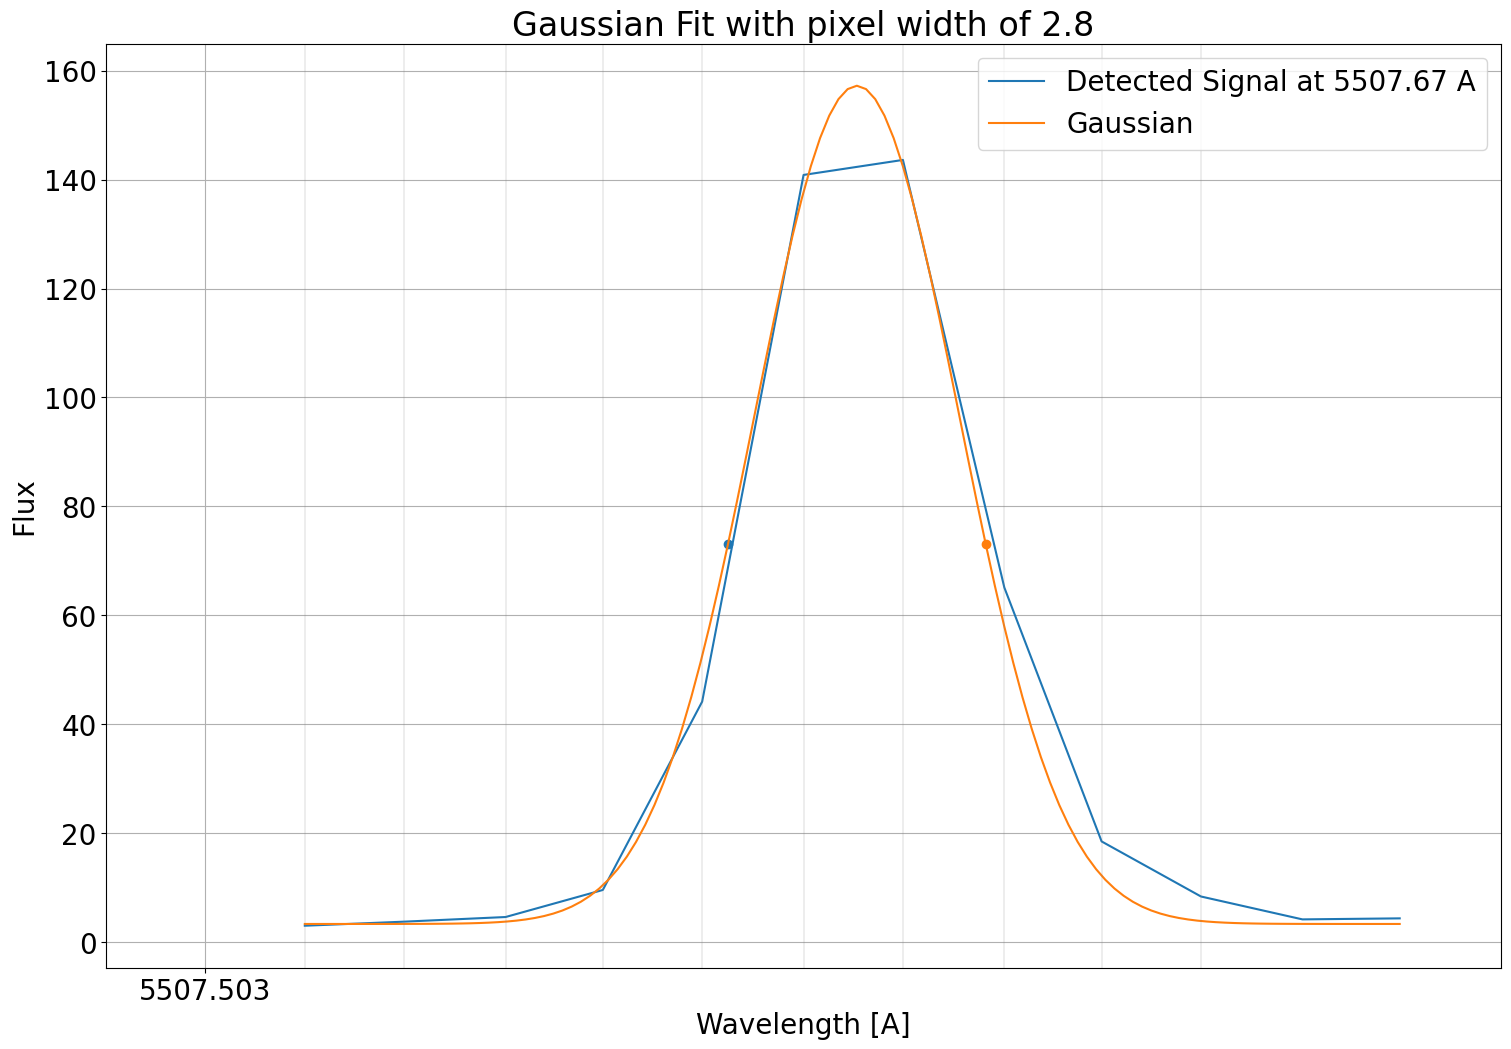

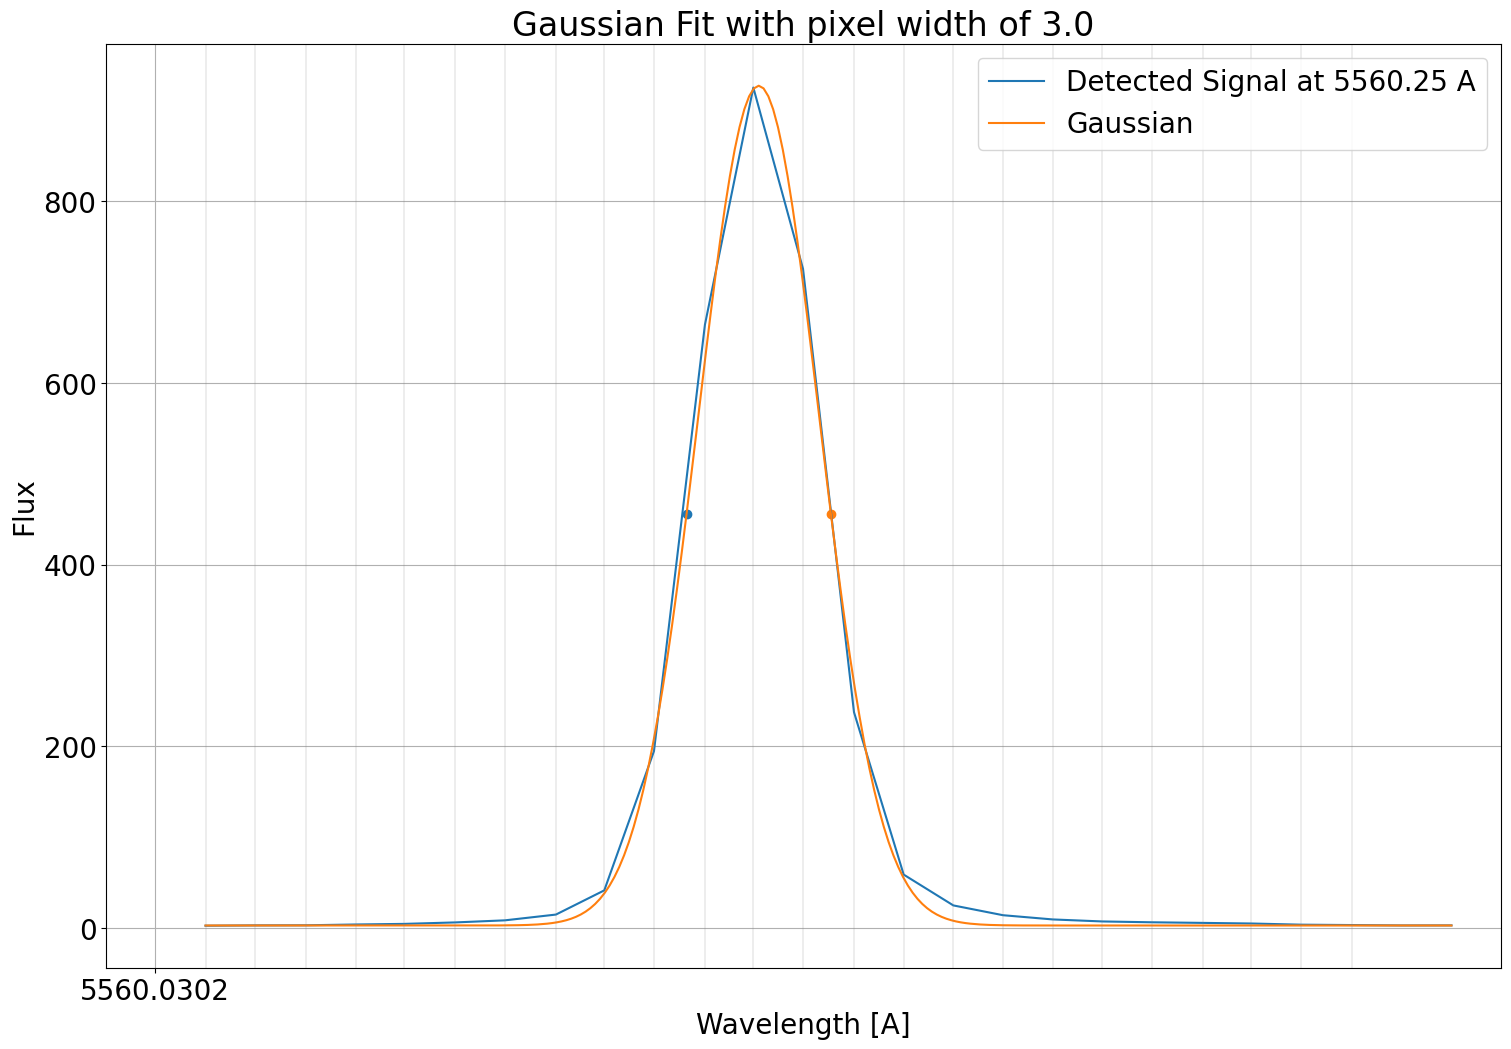

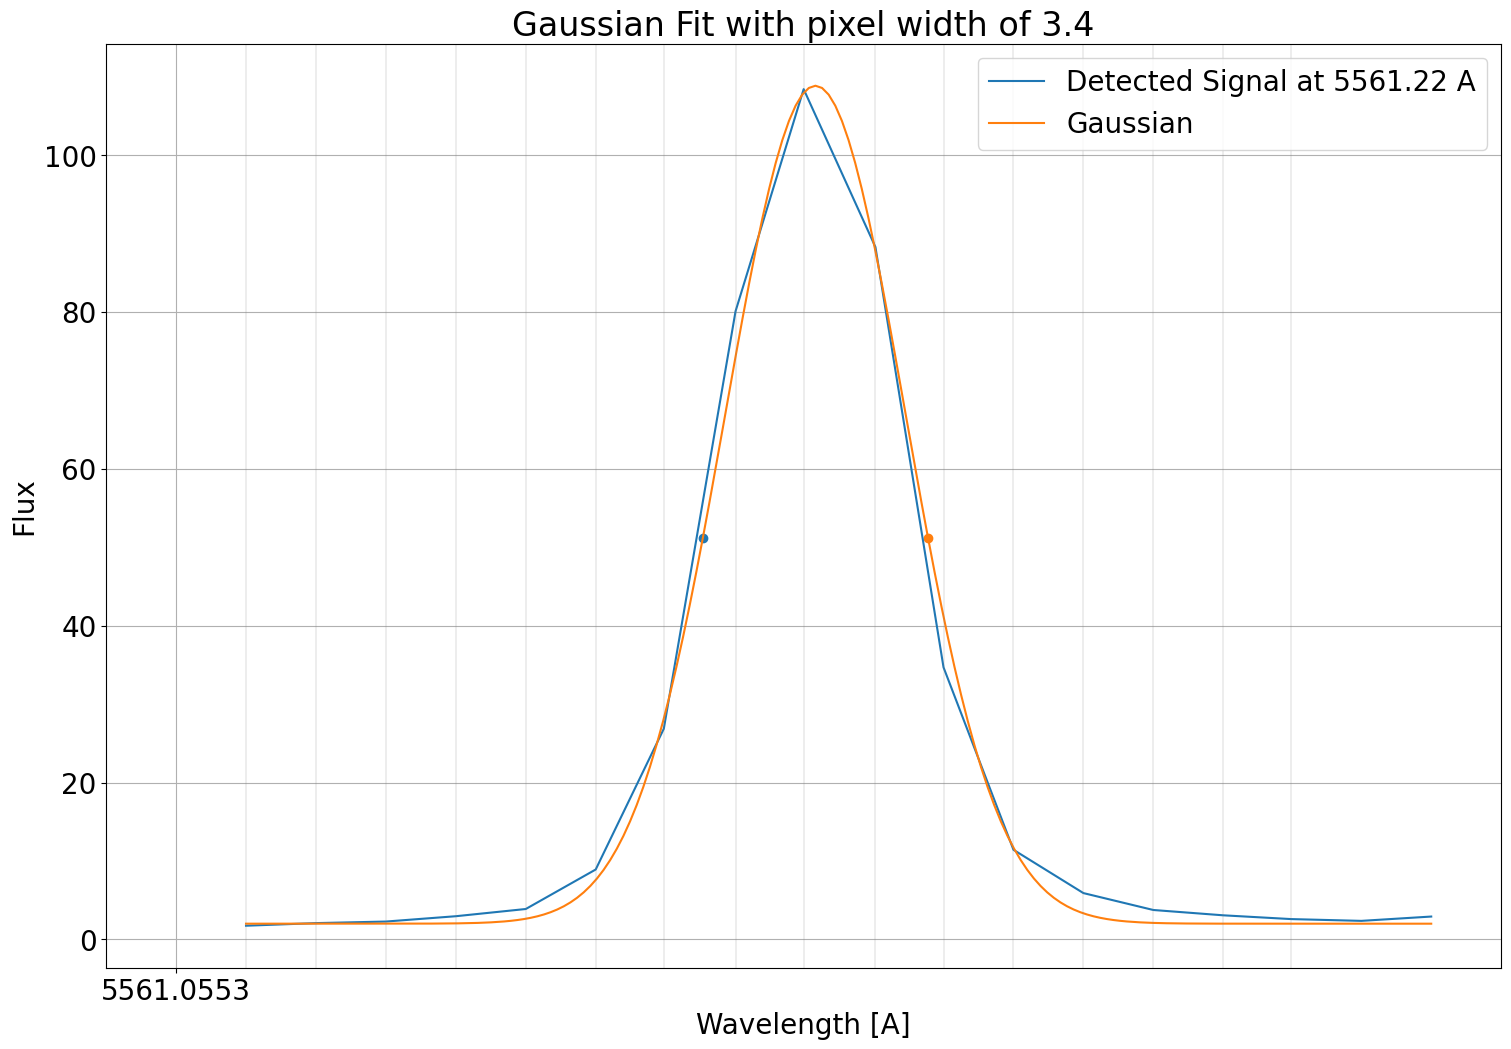

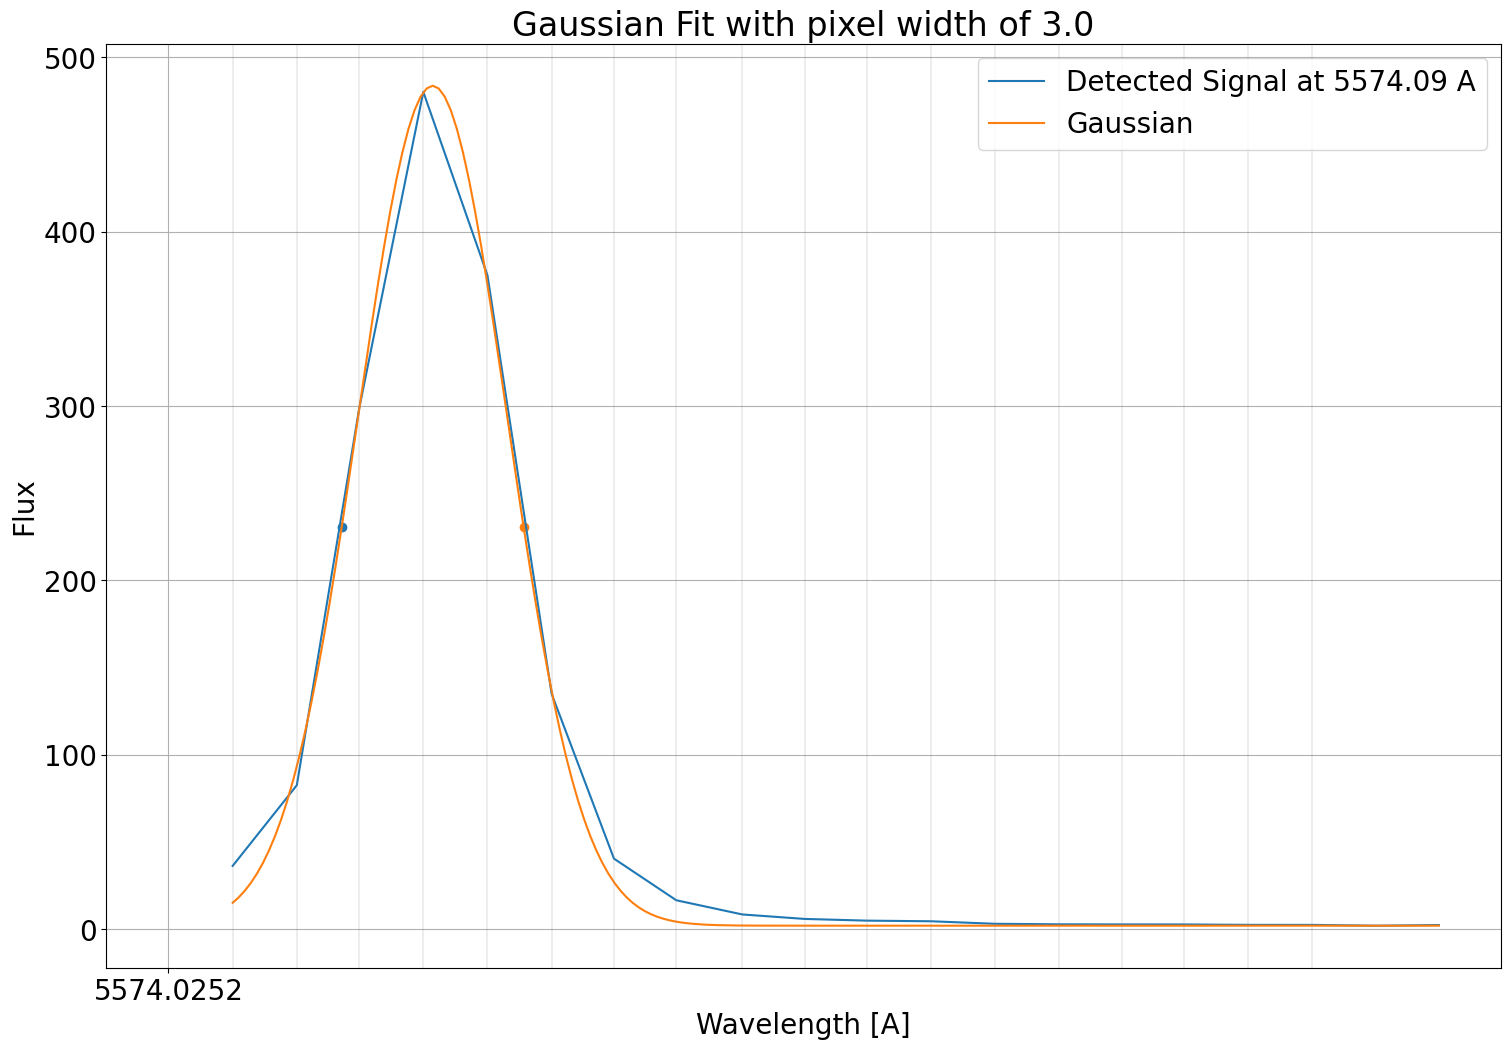

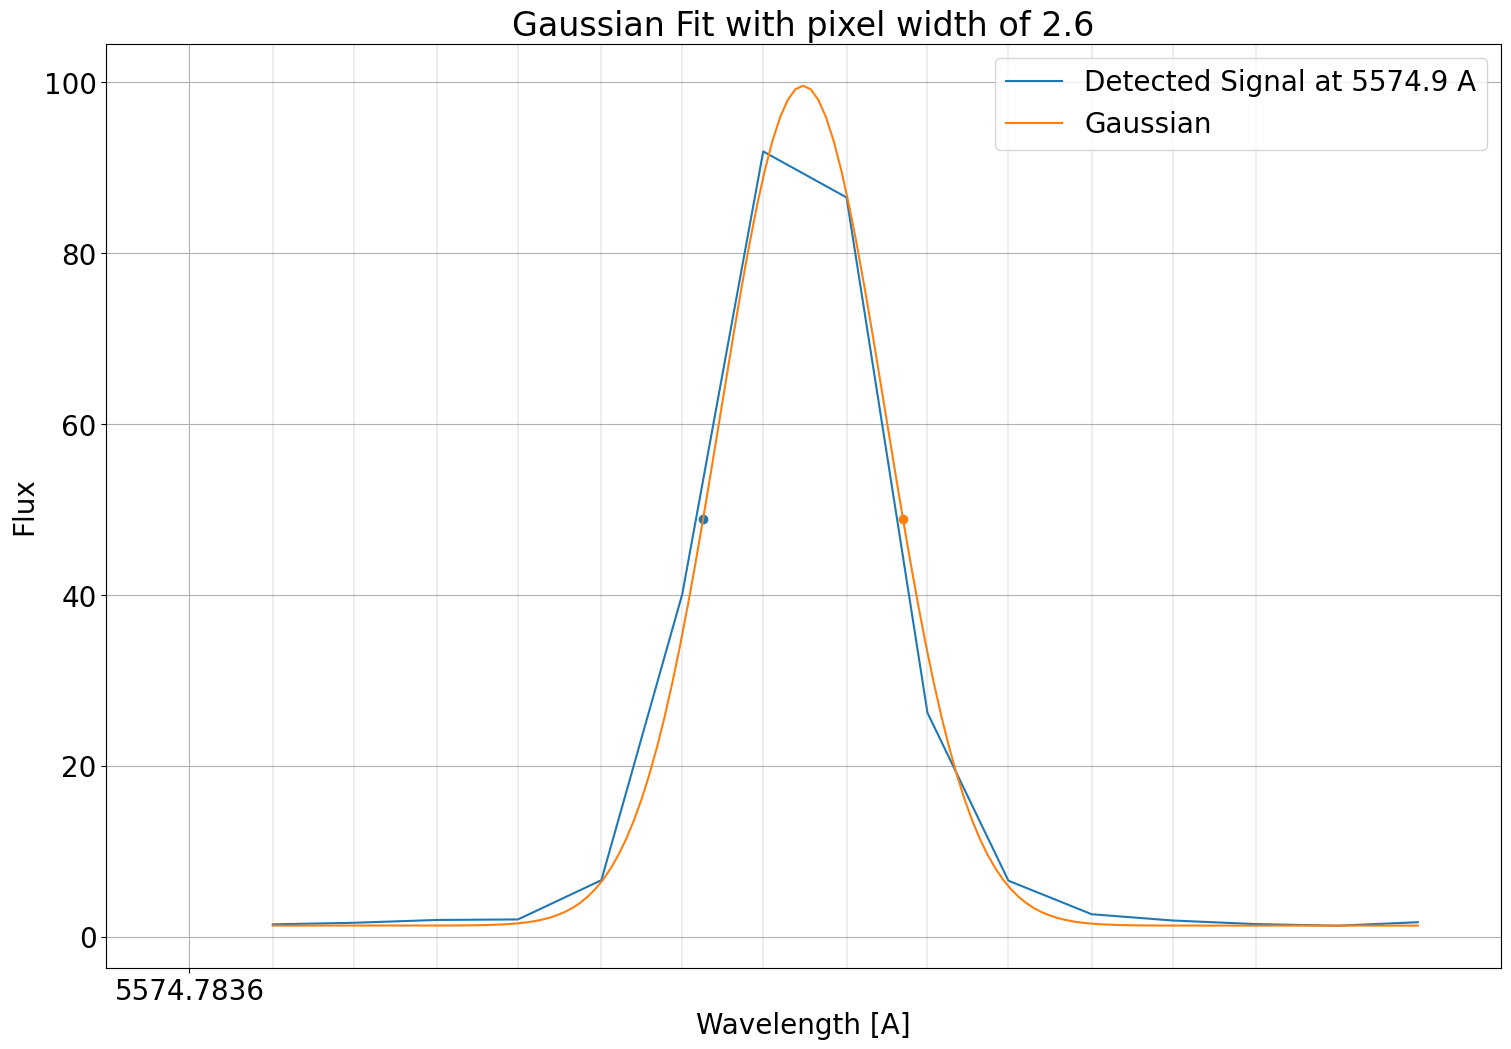

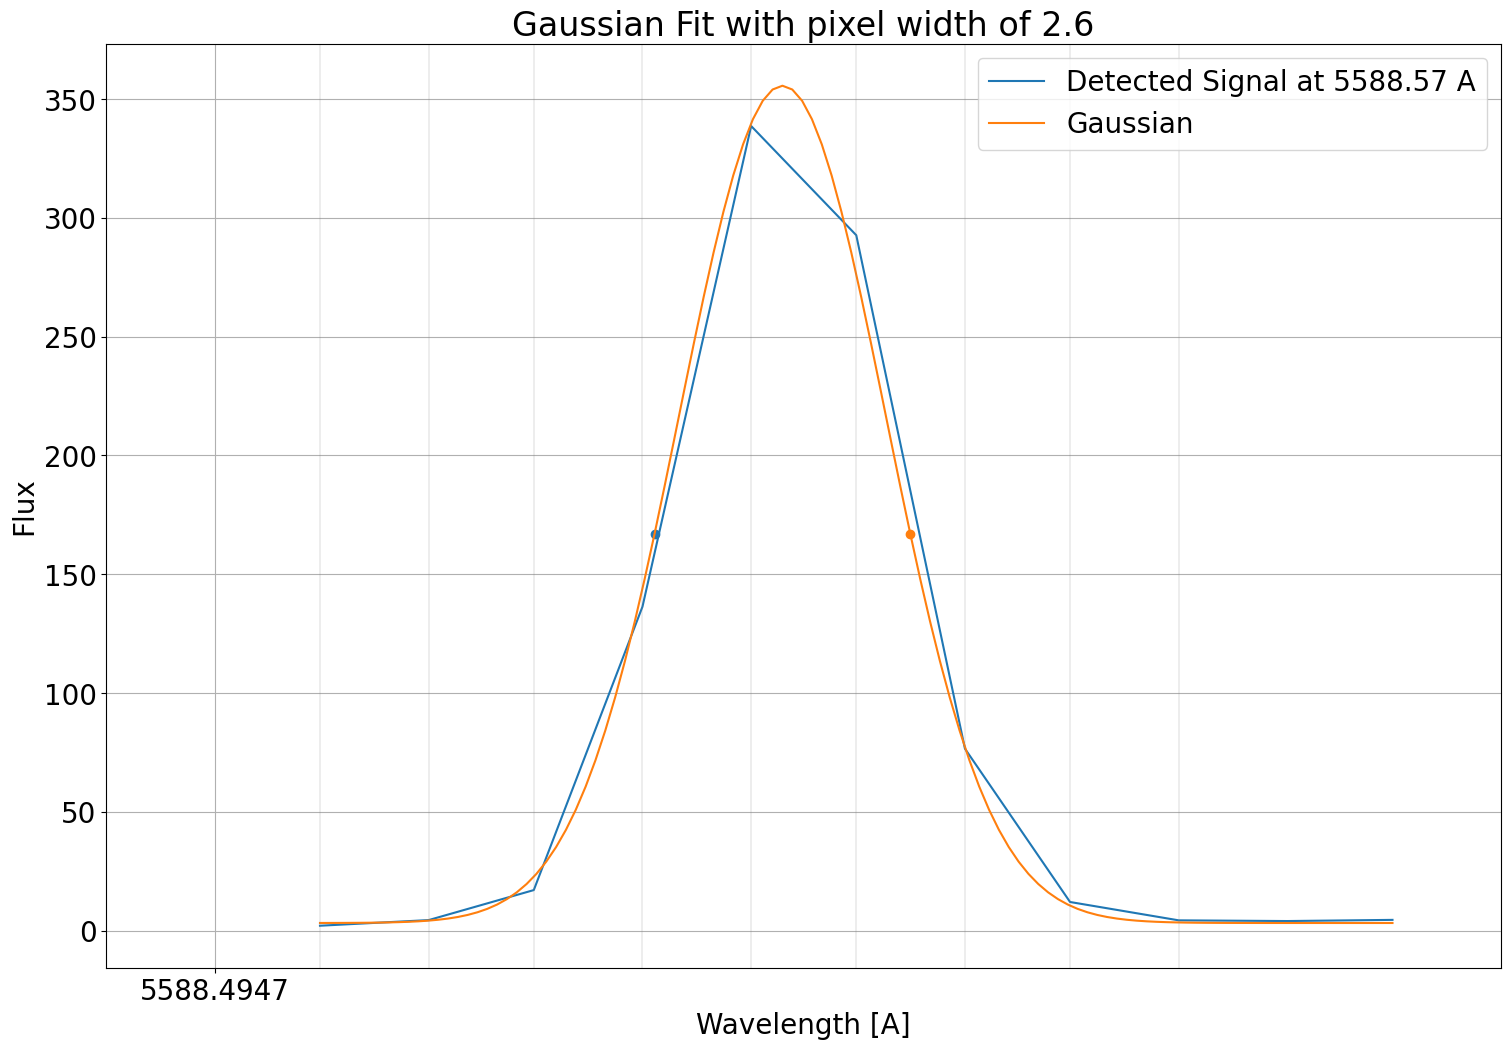

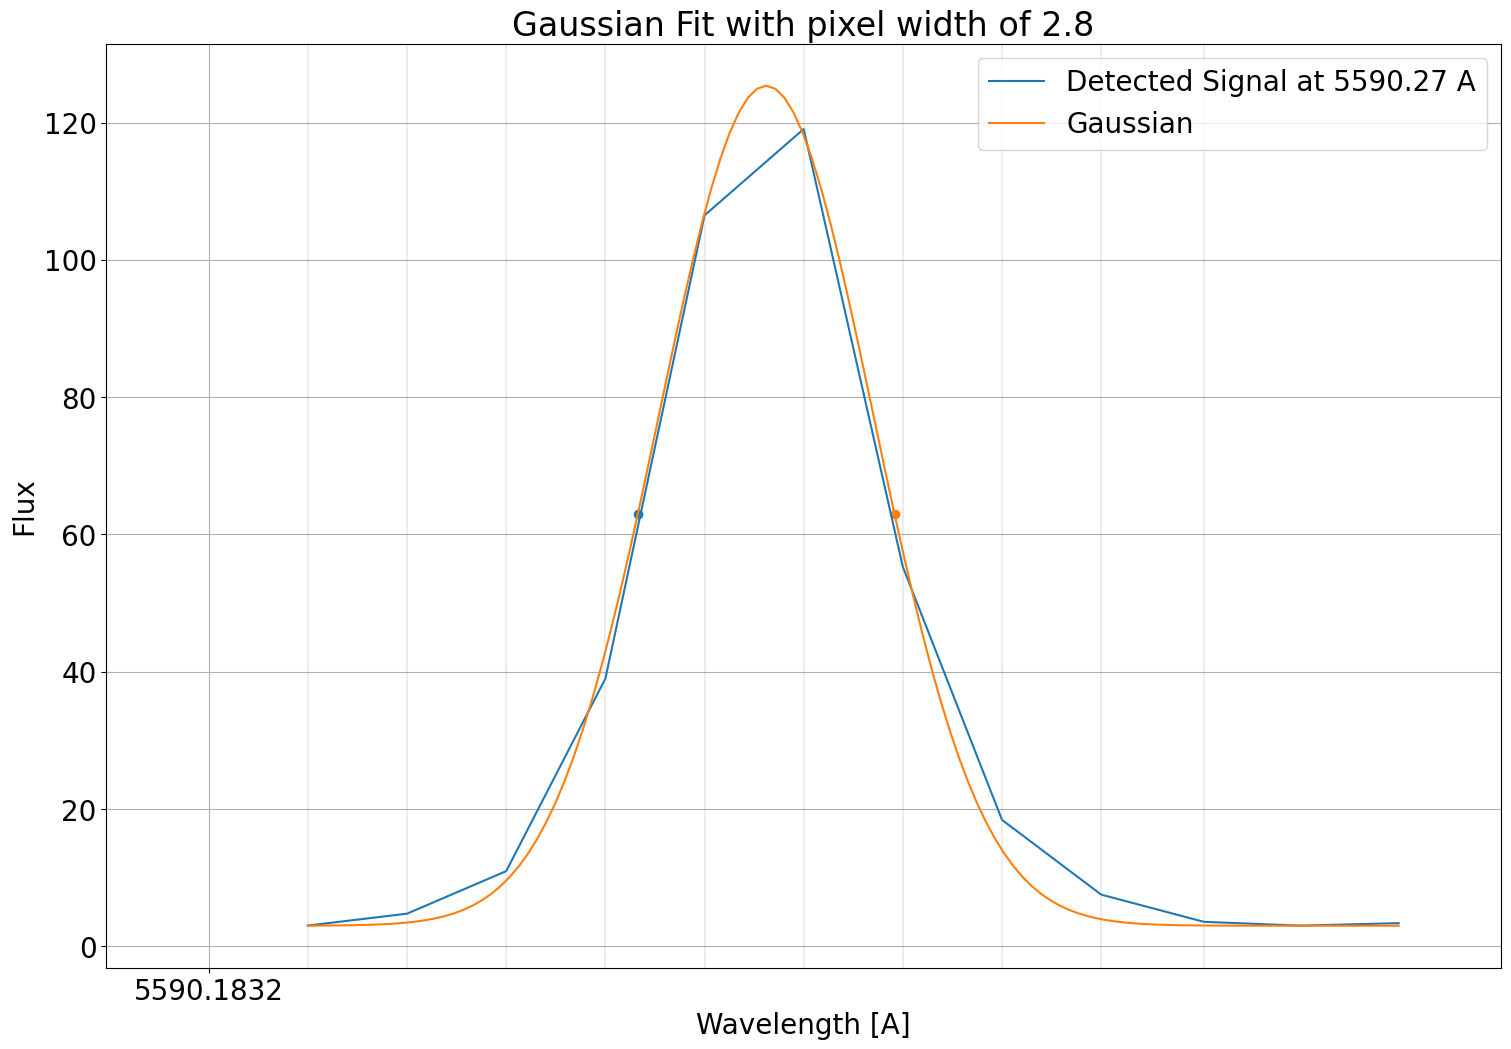

In [13]:
idxs3 = idxs2

for idx in idxs3:
    # fourth test: fit a gaussian to the peak, see how much signal resembles a gaussian
    # mark edges of signal as when flux reaches a local minimum
    # first oversample signal
    
    temp_ind = idx
    left_bound = 0
    while temp_ind > 1:
        temp_ind -= 1
        if spect[temp_ind] < spect[temp_ind - 1] and spect[temp_ind] < spect[temp_ind + 1]:
            left_bound = temp_ind
            break
    temp_ind = idx
    right_bound = len(spect) - 1
    while temp_ind < len(spect) - 4:
        temp_ind += 1
        if (spect[temp_ind] < spect[temp_ind - 1]) and (spect[temp_ind] < spect[temp_ind + 1]):
            right_bound = temp_ind
            break

    x = wl[left_bound:right_bound + 2]
    y = spect[left_bound:right_bound + 2]
    
    oversampled_x = np.linspace(x[0], x[-1], len(x) * 10)
    spl = splrep(x, y)
    oversampled_y = splev(oversampled_x, spl)
    
    
    
    max_y = max(oversampled_y)
    min_y = np.percentile(oversampled_y, 3) 
    height = max_y - min_y
    ind = oversampled_y.tolist().index(max_y)
    pos = oversampled_x[ind]
    min_width = 0.00001
    max_width = oversampled_x[len(oversampled_x) - 1] - oversampled_x[0]
    width_spacing = 0.001

    chi_squared_values = []
    width_vals = np.arange(min_width, max_width, width_spacing)
    for w in width_vals:
        gaus = gaussian(oversampled_x, height, pos, w, min_y)
        chi_squared = chi(gaus, oversampled_y)
        chi_squared_values = np.append(chi_squared_values, chi_squared)
    min_chi_squared = min(chi_squared_values)
    ind_of_min_chisquared = chi_squared_values.tolist().index(min_chi_squared)
    width = width_vals[ind_of_min_chisquared]
    gaus = gaussian(oversampled_x, height, pos, width, min_y)
    
#     plt.plot(x, y)
#     plt.plot(oversampled_x, oversampled_y)
#     plt.plot(oversampled_x, gaus)

    
    # find the width of the gaussian in pixels
    
    peak = max(gaus)
    half_max = peak - height / 2
    
    peak_index = gaus.tolist().index(peak)
    temp_left_bound = peak_index
    temp_right_bound = peak_index

    
    while gaus[temp_left_bound] > half_max and temp_left_bound > 0:
        temp_left_bound -=1
        
    while gaus[temp_right_bound] > half_max and temp_right_bound < len(gaus) - 1:
        temp_right_bound += 1
    
    pixel_width = (temp_right_bound - temp_left_bound) / 10
    
    if plot == True or save_figs == True:
        fig = plt.figure()
        plt.plot(x, y, label = 'Detected Signal at ' + str(round(wl[idx], 2)) + ' A')
#         plt.plot(oversampled_x, oversampled_y, label = 'Oversampled Signal')
        plt.plot(oversampled_x, gaus, label = 'Gaussian')
        plt.scatter(oversampled_x[temp_left_bound], gaus[temp_left_bound])
        plt.scatter(oversampled_x[temp_right_bound], gaus[temp_right_bound])
        plt.title('Gaussian Fit with pixel width of ' + str(pixel_width))
        plt.xlabel('Wavelength [A]')
        plt.xlim(wl[left_bound - 2], wl[right_bound + 2])
        plt.ylabel('Flux')
        plt.xticks(np.arange(wl[left_bound - 1], wl[right_bound + 1]))
        plt.grid(which = 'both')
        for ind in np.arange(left_bound, right_bound):
            plt.axvline(x=wl[ind], color='gray', linestyle='-', linewidth=0.2)
        plt.legend()
        plt.show()
    